In [39]:
from pathlib import Path
from ase import io
import pandas as pd
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure, Lattice
from pymatgen.transformations.site_transformations import TranslateSitesTransformation
from pymatgen.transformations.standard_transformations import SupercellTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations
import torch

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [40]:
def get_paths(model):
    pc_mapping = {
        'TD': 'new-timesteps',
        'pos-only': 'baseline'
    }
        
    initial_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_initial_structures/generated_crystals.extxyz'
        )

    generated_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}/generated_crystals.extxyz'
    )
    relaxed_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}/structures_relaxed/generated_crystals.extxyz'
        )
    df_path = Path(
        f'/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/50-steps/n-samples-per-structure/{model}-5-samples/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}/{model}-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__{pc_mapping[model]}_df_results.csv'
    )

    return initial_path, generated_path, relaxed_path, df_path

In [41]:
from pymatgen.core.operations import SymmOp


In [76]:
def get_permuted_distances(strct, sites1, sites2):
    rmsds = []
    sites1 = np.array(sites1)
    sites2 = np.array(sites2)
    
    for per in list(permutations(range(3))):
        dist_matrix = strct.lattice.get_all_distances(
            sites1,
            sites2[:, list(per)],
        )

        # solve the assignment problem to match hydrogen sites
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        matched_distances = dist_matrix[row_ind, col_ind]
        # avg_distance = np.mean(matched_distances)
        rmsd = np.linalg.norm(matched_distances) / len(sites1) ** 0.5
        
        rmsds.append(rmsd)
    print(rmsds)
    return min(rmsds)

def compute_lattice_polar_decomposition(lattice_matrix: torch.Tensor) -> torch.Tensor:
    # Polar decomposition via SVD, see https://en.wikipedia.org/wiki/Polar_decomposition
    # lattice_matrix: [batch_size, 3, 3]
    # Computes the (unique) symmetric lattice matrix that is equivalent (up to rotation) to the input lattice.

    W, S, V_transp = torch.linalg.svd(lattice_matrix)
    S_square = torch.diag_embed(S)
    V = V_transp.transpose(1, 2)
    U = W @ V_transp
    P = V @ S_square @ V_transp
    P_prime = U @ P @ U.transpose(1, 2)
    # symmetrized lattice matrix
    symm_lattice_matrix = P_prime
    return symm_lattice_matrix.squeeze(0).numpy()

def get_rmsds(initial_atoms, generated_atoms, strct_idx, matches):
    sm = StructureMatcher(primitive_cell=False)
    non_matching = 0
    rmsds = []
    matched = {}
    matched = []

    for i, gen_structure in enumerate(generated_atoms):
        ref_structure = initial_atoms[strct_idx[i]]
        
        ref_structure0 = AseAtomsAdaptor.get_structure(ref_structure)
        # ref_structure1 = Structure(
        #     lattice=Lattice(compute_lattice_polar_decomposition(torch.from_numpy(ref_structure0.lattice.matrix).unsqueeze(0))),
        #     species=ref_structure0.species,
        #     coords=ref_structure0.frac_coords,
        # )
        
        
        gen_structure = AseAtomsAdaptor.get_structure(gen_structure).get_primitive_structure().get_reduced_structure()
        
        # if not sm.fit(ref_structure, gen_structure):
        #     non_matching += 1
        #     continue
        init_transf = ref_structure0.copy().get_primitive_structure()
        ref_structure = init_transf.get_reduced_structure()
        
        

        # if not sm.fit(ref_structure, gen_structure):
        #     non_matching += 1
        #     continue
        if ref_structure.n_elems == 1:
            can_be_matched = sm.get_s2_like_s1(ref_structure.copy(), gen_structure.copy())
        else:
            can_be_matched = sm.get_s2_like_s1(
                ref_structure.copy(),#.remove_species('H'), 
                gen_structure.copy(), #.remove_species('H')
                )
            transformation = sm.get_transformation(
                ref_structure.copy(),#.remove_species('H'), 
                gen_structure.copy(),#.remove_species('H')
                )
            if transformation:
                # rotation_op = SymmOp.from_rotation_and_translation(transformation[0], transformation[1])
                # # rotated_structure = struct.copy()
                # gen_structure = gen_structure.apply_operation(rotation_op, fractional=True)
             
             
                # new_fracs = s2.frac_coords.dot(R.T) + t  
                # # wrap back into [0,1)
                # new_fracs = new_fracs % 1.0

                # # 2a) if you want s2’s lattice also rotated by R:
                # new_lat = Lattice(s2.lattice.matrix.dot(R.T))
                # # —or— 2b) if you want to drop in s1’s lattice instead:
                # # new_lat = s1.lattice

                # # 3) rebuild the structure
                # s2_match = Structure(
                #     new_lat,
                #     s2.species,
                #     new_fracs,
                #     site_properties=s2.site_properties
                # )
                transformed_manually = Structure.from_sites(gen_structure.sites)
                transformed_manually.make_supercell(transformation[0])
                transformed_manually.translate_sites(list(range(len(gen_structure))), transformation[1])
        
        if can_be_matched is None:
            print(f"Structure {i} does not match the reference structure.")
            non_matching += 1
            continue
            
        # gen_structure = can_be_matched
        
        # gen_structure = sm.get_s2_like_s1(ref_structure, gen_structure)
        # if gen_structure is None:
        #     # print(f"Structure {i} does not match the reference structure.")
        #     non_matching += 1
        #     continue
        
        # matched[strct_idx[i]] = matched.get(strct_idx[i], 0) + 1
        # if not matches[i]:
        #     continue
        
        # extract hydrogen sites from both structures
        gen_H_sites = [site.frac_coords for site in transformed_manually if site.specie.symbol == 'H']
        ref_H_sites = [site.frac_coords for site in ref_structure if site.specie.symbol == 'H']

        if len(gen_H_sites) != len(ref_H_sites):
            print(f"Mismatch in hydrogen count: generated={len(gen_H_sites)}, reference={len(ref_H_sites)}")
        else:
            # build a cost matrix of distances between hydrogen sites
            dist_matrix = ref_structure.lattice.get_all_distances(
                gen_H_sites,
                ref_H_sites,
            )

            # solve the assignment problem to match hydrogen sites
            row_ind, col_ind = linear_sum_assignment(dist_matrix)
            matched_distances = dist_matrix[row_ind, col_ind]
            # avg_distance = np.mean(matched_distances)
            rmsd = np.linalg.norm(matched_distances) / len(ref_H_sites) ** 0.5
            rmsds.append(rmsd)

            if rmsd > 1:
                # print(rmsd, sm.fit(ref_structure, gen_structure))
                if ref_structure.n_elems == 1:
                    continue
                # matched_s = sm.get_s2_like_s1(ref_structure.copy(), gen_structure.copy())
                print(ref_structure, gen_structure, transformed_manually)
                # print('lattice', gen_structure.lattice, ref_structure.lattice)
                # print('transformed', matched_s)
                # print(sm.fit(ref_structure, gen_structure), sm.get_rms_dist(
                #     ref_structure.copy().remove_sites([i for i in range(len(ref_structure)) if ref_structure[i].specie.symbol != 'H']), 
                #     gen_structure.copy().remove_sites([i for i in range(len(gen_structure)) if gen_structure[i].specie.symbol != 'H'])
                #     )
                #       )
                # print(sm.get_transformation(ref_structure, gen_structure))
                # print(sm.get_transformation(ref_structure.copy().remove_species('H'), gen_structure.copy().remove_species('H')))
                # print('perm distances ', get_permuted_distances(ref_structure, gen_H_sites, ref_H_sites))
                # print('polar decomp', 
                #     list(Lattice(compute_lattice_polar_decomposition(torch.from_numpy(ref_structure0.lattice.matrix).unsqueeze(0))).find_all_mappings(
                #         ref_structure0.lattice
                #     )
                # ))
                
            # print(f"Average hydrogen distance: {avg_distance:.3f}")
            # print(f"RMSD of hydrogen sites: {rmsd:.3f}")
            
    print(f"Total number of structures: {len(generated_atoms)}")
    print(f"Number of non-matching structures: {non_matching}")
    
    return rmsds, matched

In [77]:
results = {}

for model in ['TD', 'pos-only']:
    initial_path, generated_path, relaxed_path, df_path = get_paths(model)
    initial_atoms = io.read(initial_path, index=':')
    generated_atoms = io.read(generated_path, index=':')
    relaxed_atoms = io.read(relaxed_path, index=':')
    
    df = pd.read_csv(
        df_path
    )
    ref_keys = df['ref_key'].to_list()
    strct_idx = df['ref_key'].apply(lambda x: int(x.split('-')[0])).to_list()
    
    rmsds, matched = get_rmsds(initial_atoms, generated_atoms, strct_idx, (df['Matches']).to_list())
    rmsds_relaxed, matched_relaxed = get_rmsds(initial_atoms, relaxed_atoms, strct_idx, (df['Matches after relaxation']).to_list())
    
    results.update({
        f'{model} unrelaxed': rmsds,# [r for i, r in enumerate(rmsds) if matched[i]],
    })
    results.update({
        f'{model} relaxed': rmsds_relaxed, #[r for i, r in enumerate(rmsds_relaxed) if matched[i]],
    })

Structure 1 does not match the reference structure.
Structure 9 does not match the reference structure.
Full Formula (Zr2 H2 Br2)
Reduced Formula: ZrHBr
abc   :   3.505572   3.505572  10.773219
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (6)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Zr    0.666667  0.333333  0.872247
  1  Zr    0.333333  0.666667  0.127753
  2  H     0         0         0.901668
  3  H     0         0         0.098332
  4  Br    0.666667  0.333333  0.303118
  5  Br    0.333333  0.666667  0.696882 Full Formula (Zr2 H2 Br2)
Reduced Formula: ZrHBr
abc   :   3.505573   3.505572  10.773219
angles:  89.999997  90.000005 120.000005
pbc   :       True       True       True
Sites (6)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Zr    0.333333  0.666667  0.127753
  1  Zr    0.666667  0.333333  0.872247
  2  Br    0.333333  0.666667  0.696882
  3  Br    0

In [78]:
results_df = pd.DataFrame({key: pd.Series(val) for key, val in results.items()})

In [79]:
results_df.shape

(3329, 4)

In [18]:
results_df.quantile(np.arange(0, 1.05, 0.05))

,TD unrelaxed,TD relaxed,pos-only unrelaxed,pos-only relaxed
0.00,0.000657,0.000101,0.000952,0.000050
0.05,0.003620,0.001005,0.007777,0.001077
0.10,0.004926,0.001491,0.010562,0.001488
0.15,0.006314,0.002063,0.012928,0.001964
0.20,0.007659,0.002531,0.015189,0.002493
0.25,0.009429,0.003024,0.017556,0.003029
0.30,0.011131,0.003596,0.020007,0.003840
0.35,0.013214,0.004295,0.022606,0.004669
0.40,0.015124,0.004986,0.025274,0.005681
0.45,0.017717,0.005949,0.028565,0.006748


In [80]:
results_df.quantile(np.arange(0, 1.05, 0.05))

,TD unrelaxed,TD relaxed,pos-only unrelaxed,pos-only relaxed
0.00,0.000657,0.000101,0.000952,0.000050
0.05,0.003667,0.001016,0.008246,0.001100
0.10,0.005023,0.001527,0.010998,0.001519
0.15,0.006424,0.002144,0.013573,0.002036
0.20,0.007969,0.002587,0.016136,0.002604
0.25,0.009768,0.003076,0.018713,0.003248
0.30,0.011635,0.003716,0.021458,0.004145
0.35,0.013712,0.004432,0.024615,0.004933
0.40,0.015888,0.005238,0.027943,0.005989
0.45,0.018681,0.006162,0.031778,0.007192


In [14]:
results_df.max()

TD unrelaxed          0.655540
TD relaxed            0.701445
pos-only unrelaxed    0.691767
pos-only relaxed      0.704715
dtype: float64

Text(0, 0.5, 'Cumulative Percent (\\%)')

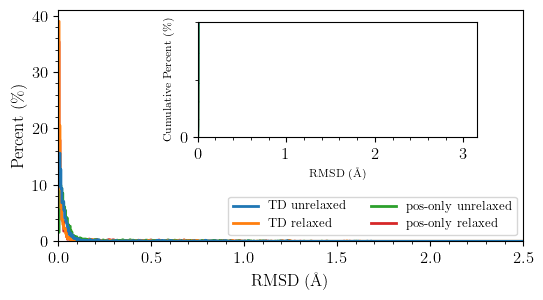

In [81]:
fig, ax = plt.subplots(nrows=1, figsize=(6, 3))

plt.subplots_adjust(hspace=0.3)

ax = [ax]
sns.histplot(
    data=results_df.melt(
        var_name='model',
        value_name='rmsd',
        value_vars=['TD unrelaxed', 'TD relaxed', 'pos-only unrelaxed', 'pos-only relaxed']
    ),
    x='rmsd',
    hue='model',
    bins=np.arange(0, 3, 0.005),
    fill=False,
    stat='percent',
    common_norm=False,
    element='step',
    linewidth=2,
    ax=ax[0],
)
ax[0].set_xlim(0, 2.5)
ax[0].set_xlabel('RMSD (Å)')
ax[0].set_ylabel('Percent (\%)')
sns.move_legend(ax[0], loc='lower right', ncol=2, title=None)

# Create an inset axis in the upper right of ax[0]
inset_ax = ax[0].inset_axes([0.3, 0.45, 0.6, 0.5])
sns.histplot(
    data=results_df.melt(
        var_name='model',
        value_name='rmsd',
        value_vars=['TD unrelaxed', 'TD relaxed', 'pos-only unrelaxed', 'pos-only relaxed']
    ),
    x='rmsd',
    hue='model',
    bins=np.arange(0, 3, 0.0005),
    fill=False,
    stat='percent',
    common_norm=False,
    element='step',
    linewidth=2,
    ax=inset_ax,
    cumulative=True,
    legend=False,
)
inset_ax.set_yticks(np.arange(0, 121, 20))
inset_ax.set_xlim(0, None)
# inset_ax.set_xlim(0, 0.2)
inset_ax.set_ylim(0, 10)
inset_ax.set_xlabel('RMSD (Å)', fontsize=8)
inset_ax.set_ylabel('Cumulative Percent (\%)', fontsize=8)

# plt.savefig(
#     'generated_structures_rmsd.pdf', bbox_inches='tight'
#     )


<Axes: ylabel='Percent'>

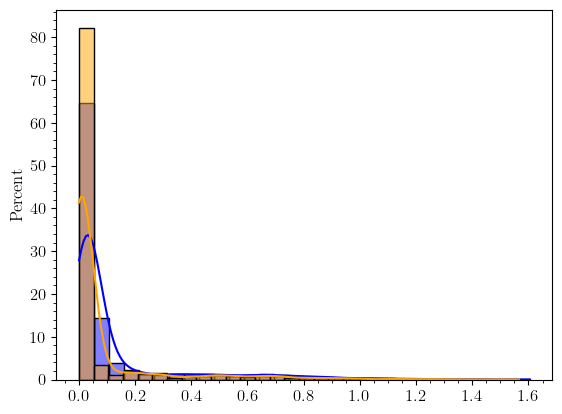

In [290]:
sns.histplot(
    data=rmsds,
    bins=30,
    kde=True,
    stat='percent',
    color='blue',
)
sns.histplot(
    data=rmsds_relaxed,
    bins=30,
    kde=True,
    stat='percent',
    color='orange',
)